In [3]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import math

In [4]:
img1 = cv.imread('1.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('2.png', cv.IMREAD_GRAYSCALE)

In [5]:
def sad(a, b) :
    return np.sum(cv.absdiff(a, b))

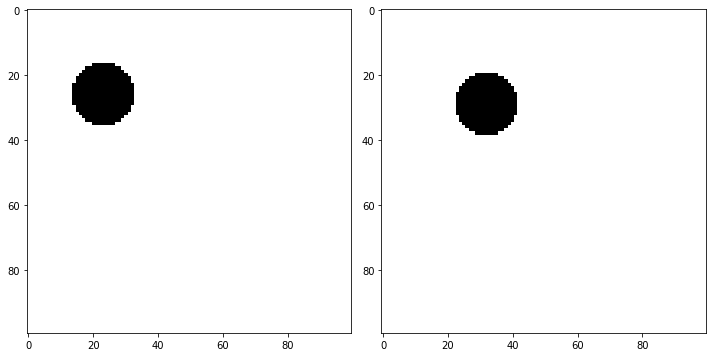

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()

In [7]:
def draw_arrows(image, movement, block_size, color=(255,)):
    for i in range(movement.shape[0]):
        for j in range(movement.shape[1]):
            di, dj = movement[i, j]
            if di == 0 and dj == 0:
                continue
            start_point = (j * block_size + (block_size // 2),      i * block_size + (block_size // 2))
            end_point   = (j * block_size + (block_size // 2) + dj, i * block_size + (block_size // 2) + di)
#             start_point = (j * block_size ,     i * block_size )
#             end_point   = (j * block_size + dj, i * block_size + di)
            cv.arrowedLine(image, start_point, end_point, color)

In [8]:
def fullSearch(img_origin, img_mod, block_size=16, search_size=32) :

    movement = np.zeros(shape=(img_origin.shape[0]//block_size, img_origin.shape[1]//block_size, 2), dtype=np.int64)
        
    for i in range(0,img_origin.shape[0] - (search_size + block_size), block_size) :
        for j in range(0,img_origin.shape[1] - (search_size + block_size), block_size) :
            
            left_border   = j
            right_border  = j + block_size
            bottom_border = i + block_size
            top_border    = i

            rec_img_origin = img_origin[top_border:bottom_border, left_border:right_border]
            
            sad_min = -1
            k_min   = 0
            l_min   = 0
            
            for k in range(search_size) :
                for l in range(search_size) :
                    
                    left_border_mod   = l              + j
                    right_border_mod  = l + block_size + j
                    bottom_border_mod = k + block_size + i
                    top_border_mod    = k              + i

                    rec_img_mod = img_mod[top_border_mod:bottom_border_mod, left_border_mod:right_border_mod]
                    
                    sad_step = sad(rec_img_origin, rec_img_mod)
                    
                    if sad_step < sad_min or sad_min == -1 or \
                       sad_step * 0.9 < sad_min and k + l < k_min + l_min :
                        sad_min = sad_step
                        k_min   = k
                        l_min   = l

            movement[i//block_size][j//block_size][0] = k_min
            movement[i//block_size][j//block_size][1] = l_min
            
    return movement

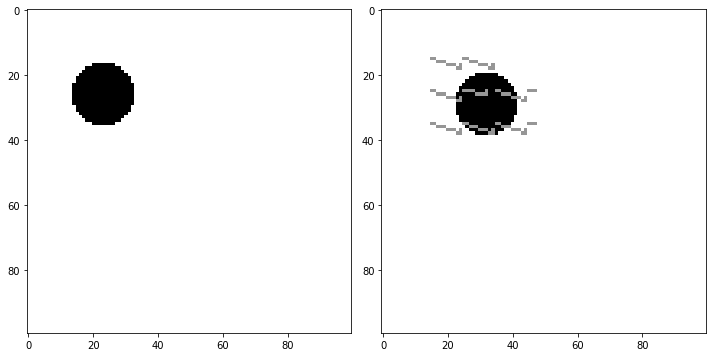

In [304]:
img1 = cv.imread('1.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('2.png', cv.IMREAD_GRAYSCALE)

block_size  = 10
search_size = 20

movement = fullSearch(img1, img2, block_size, search_size)

draw_arrows(img2, movement, block_size, color=150)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()

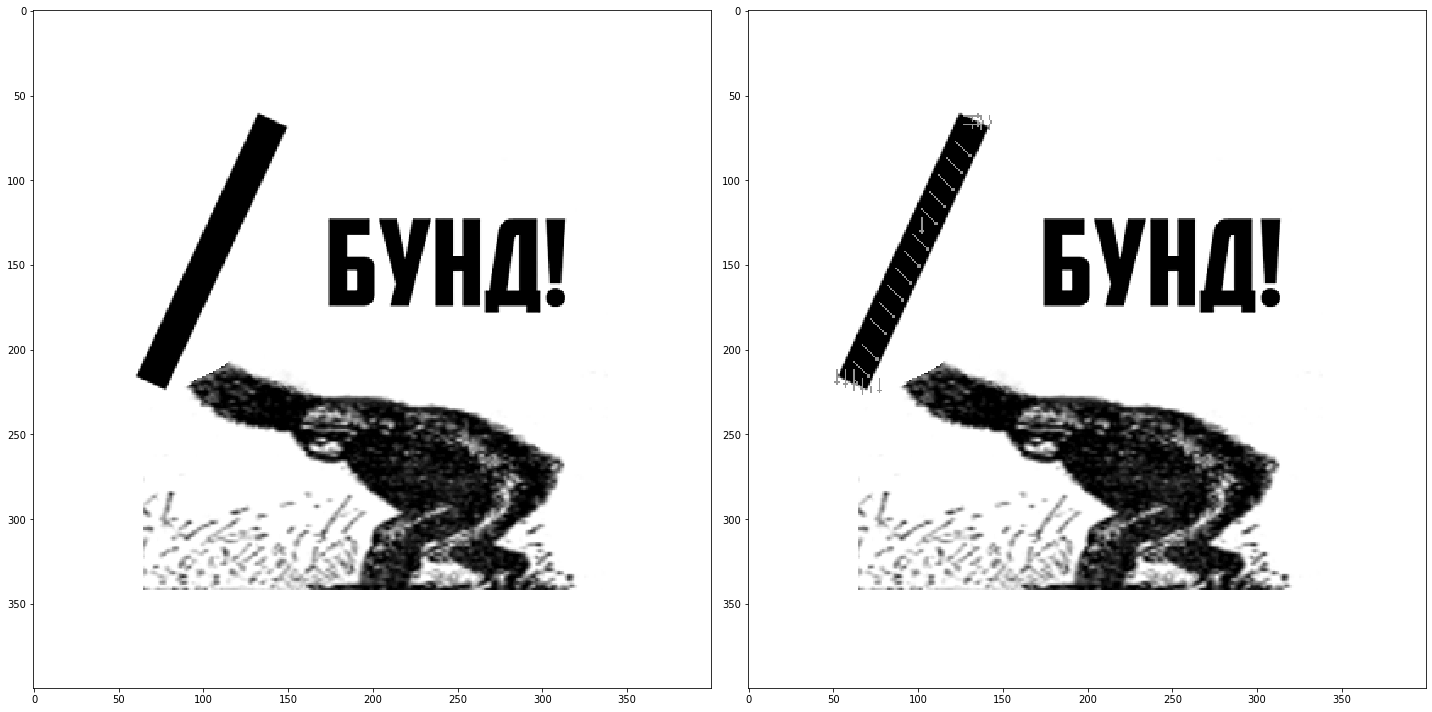

In [7]:
img1 = cv.imread('3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('4.png', cv.IMREAD_GRAYSCALE)

block_size  = 5
search_size = 10

movement = fullSearch(img1, img2, block_size, search_size)
draw_arrows(img2, movement, block_size, color=150)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()

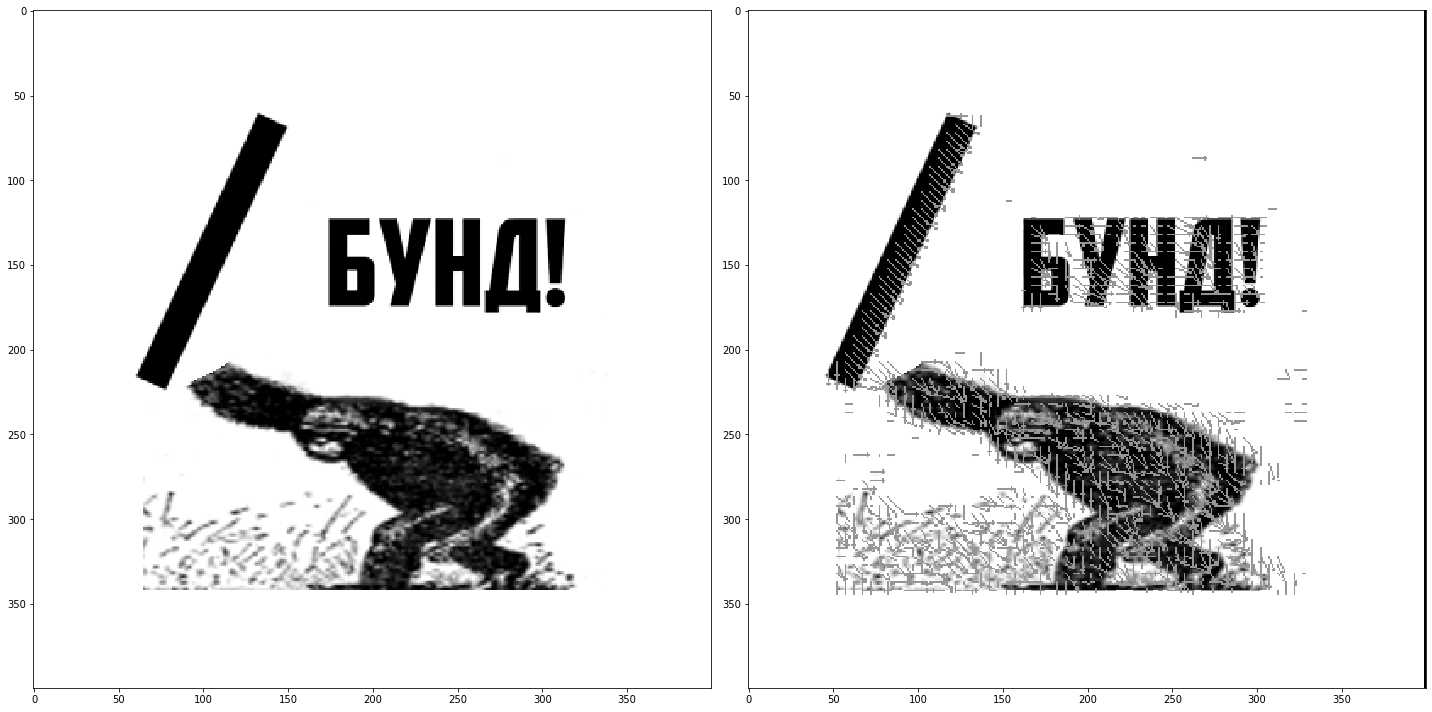

In [306]:
img1 = cv.imread('3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('5.png', cv.IMREAD_GRAYSCALE)

block_size  = 5
search_size = 10

movement = fullSearch(img1, img2, block_size, search_size)
draw_arrows(img2, movement, block_size, color=150)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()

In [212]:
def diamondSearch(img_origin, img_mod, block_size=16, search_size=32) :

    movement = np.zeros(shape=(img_origin.shape[0]//block_size, img_origin.shape[1]//block_size, 2), dtype=np.int64)
    
    diamond_direction_LDSP = [
         [ 0, 0]
        ,[ 0, 2]
        ,[ 1, 1]
        ,[ 2, 0]
        ,[ 1,-1]
        ,[ 0,-2]
        ,[-1,-1]
        ,[-2, 0]
        ,[-1, 1]
    ]
    
    diamond_direction_SDSP = [
         [ 0, 0]
        ,[ 0, 1]
        ,[ 1, 0]
        ,[ 0,-1]
        ,[-1, 0]
        ,[ 0, 0]
    ]
        
    for i in range(search_size//2,img_origin.shape[0] - (search_size//2 + block_size), block_size) :
        for j in range(search_size//2,img_origin.shape[1] - (search_size//2 + block_size), block_size) :
            
            left_border   = j
            right_border  = j + block_size
            bottom_border = i + block_size
            top_border    = i

            rec_img_origin = img_origin[top_border:bottom_border, left_border:right_border]
                        
            sad_space = np.full((search_size,search_size),np.inf)
                        
            def sadForPoint(rec_img_origin, img_mod, k, l) :
                
                left_border_mod   = l
                right_border_mod  = l + block_size
                bottom_border_mod = k + block_size
                top_border_mod    = k

                rec_img_mod = img_mod[top_border_mod:bottom_border_mod, left_border_mod:right_border_mod]
                return sad(rec_img_origin, rec_img_mod)

            def calculateDSP(k_center, l_center, diamond_array) :
                
                if k_center > search_size//2 or k_center < -search_size//2 or l_center > search_size//2 or l_center < -search_size//2 : 
                    return (k_center, l_center)
                
                k_center_img = k_center + i
                l_center_img = l_center + j
                
                sad_local_min = sad_space[k_center, l_center]
                k_local_min   = k_center
                l_local_min   = l_center
                
                for (dk,dl) in diamond_array :
                    if sad_space[k_center + dk, l_center + dl] == np.inf :
                        sad_step = sadForPoint(rec_img_origin, img_mod, k_center_img + dk, l_center_img + dl)
                        sad_space[k_center + dk, l_center + dl] = sad_step
                
                        if sad_step < sad_local_min :
                            sad_local_min = sad_step
                            k_local_min   = k_center + dk
                            l_local_min   = l_center + dl
                            
                return (k_local_min, l_local_min)
        
        
            dk = 0
            dl = 0
                                        
            while True :
                dk_next, dl_next = calculateDSP(dk,dl,diamond_direction_LDSP)
                
                if dk == dk_next and dl == dl_next :
                    break
                                        
                dk = dk_next
                dl = dl_next
            
            while True :                
                dk_next, dl_next = calculateDSP(dk,dl,diamond_direction_SDSP)
                
                if dk == dk_next and dl == dl_next :
                    break
                
                dk = dk_next
                dl = dl_next
                      
            k_min = dk
            l_min = dl

            
            movement[i//block_size][j//block_size][0] = k_min
            movement[i//block_size][j//block_size][1] = l_min
            
    return movement

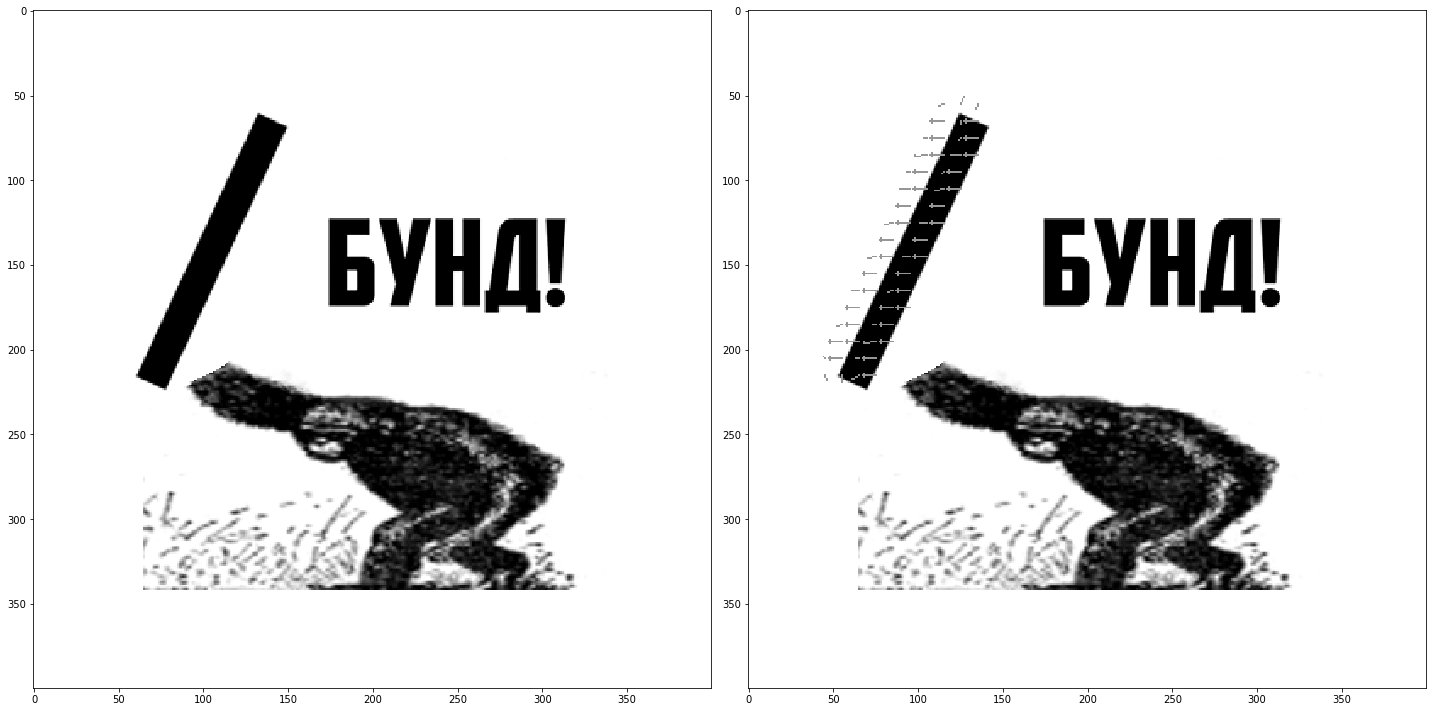

In [217]:
img1 = cv.imread('3.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('4.png', cv.IMREAD_GRAYSCALE)

block_size  = 10
search_size = 30

movement = diamondSearch(img1, img2, block_size, search_size)
draw_arrows(img2, movement, block_size, color=150)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()